# Exploratory Data Analysis

### Content
- [1. Standard Imports](#-1.-Standard-Imports)
- [2. Importing translated dataframe](#-2.-Importing-translated-dataframe)
- [3. Mapping to Target Columns](#-3.-Mapping-to-Target-Columns)
- [4. Creating Additional Stopwords](#-4.-Creating-Additional-Stopwords)
- [5. Preprocessing 'reviews' column](#-5.-Preprocessing-'reviews'-column)
- [6. Plotting Word Clouds☁️☁️☁️](#-6.-Plotting-Word-Clouds☁️☁️☁️)
- [7. Plotting Unigram Barplots](#-7.-Plotting-Unigram-Barplots)
- [8. Plotting Bigram/Trigram Barplots](#-8.-Plotting-Bigram/Trigram-Barplots)
- [9. Visualizing topics using pyLDAvis](#-9.-Visualizing-topics-using-pyLDAvis)

### 1. Standard Imports

In [1]:
# all the standard imports for python API
import pandas as pd
import numpy as np

# standard imports for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
%matplotlib inline

# standard imports for regular expression and text cleaning
import regex as re
from bs4 import BeautifulSoup   
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# word cloud import
from wordcloud import WordCloud, STOPWORDS

# CountVectorizer Import
from sklearn.feature_extraction.text import CountVectorizer

### 2. Importing translated dataframe

In [2]:
translated_df = pd.read_csv('trans_df.csv')

In [3]:
translated_df.drop_duplicates(inplace=True)

translated_df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language
0,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"This course is really very practical, the way ...",By Luisa F P G,2020-05-11,5.0,69,University,5,2020,May-2020,2020-05,en
1,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,"Very happy for the content of the course, I pr...",By Liliana B,2020-06-19,5.0,60,University,6,2020,Jun-2020,2020-06,en


In [4]:
translated_df.isnull().sum()

name              0
institution       0
course_url        0
course_id         0
reviews           0
reviewers         0
date_reviews      0
rating            0
count of words    0
University        0
month             0
year              0
mth-year          0
year-month        0
language          0
dtype: int64

In [5]:
# assign this dataframe as eda_df
eda_df = translated_df

eda_df['count of words'] = [len(review.split(' ')) for review in eda_df['reviews']]

# decided to only use dataframes with minimum 5 words
eda_df = eda_df[eda_df['count of words'] >= 5]

### 3. Mapping-to-Target-Columns

- Majority of `rating` belong to **5.0** (77%) while other `rating` from **1.0 to 4.0** (23%).
- `rating` **0.5** will be assigned as 1 in `target` column
- As the value_counts for `rating` from **1.0 to 4.0** are low, they will be assigned as 0 in `target` column and for reviewers to rate **1.0 to 4.0** there has to be a certain level of disatisfaction instead of rating **5.0**


In [6]:
eda_df['rating'].value_counts()

5.0    315381
4.0     66891
3.0     15572
1.0      5751
2.0      5554
Name: rating, dtype: int64

In [7]:
eda_df = eda_df.copy()
eda_df['target'] = [1 if x==5 else 0 for x in eda_df['rating']]

In [8]:
eda_df[['rating', 'target']].value_counts()

rating  target
5.0     1         315381
4.0     0          66891
3.0     0          15572
1.0     0           5751
2.0     0           5554
dtype: int64

In [9]:
eda_df[['target']].value_counts()

target
1         315381
0          93768
dtype: int64

In [10]:
eda_df[['target']].value_counts(normalize=True)

target
1         0.770822
0         0.229178
dtype: float64

In [11]:
pd.DataFrame(eda_df[['target']].value_counts(normalize=True))

,0
target,
1,0.770822
0,0.229178


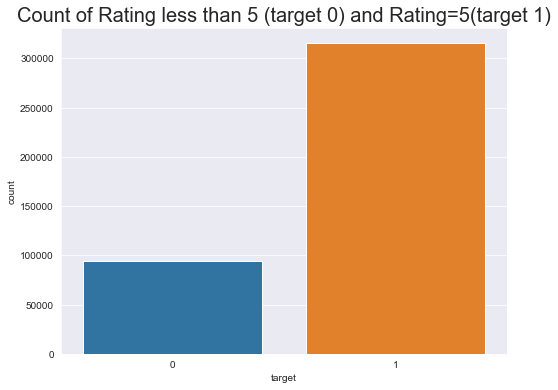

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x='target', data=eda_df)
plt.title('Count of Rating less than 5 (target 0) and Rating=5(target 1)', fontsize=20);
plt.tick_params(labelsize=10)

In [11]:
# checking the dataframe
eda_df.loc[129, 'reviews']

'Very good course! You learn the basics of nutrition and good food. '

### 4. Creating Additional Stopwords

- `institution` & `name` of the courses are added in stopwords as there will be some courses more popular and reviewed more.
- By removing `institution` & `name` of the courses, other words regarding their thoughts about courses in general can be visualized better during EDA.

In [13]:
list_of_institution = eda_df['institution'].unique().tolist()

result = ''
for i in list_of_institution:
    result += (' ' + i)
    
institute_result = re.sub("[^a-zA-Z]", " ", result)
institute_result = institute_result.lower().strip().split()
institute_result = list(set(institute_result))
len(institute_result)

217

In [14]:
institute_result[:10]

['rutgers',
 'noma',
 'research',
 'the',
 'medical',
 'sas',
 'gitlab',
 'school',
 'services',
 's']

In [15]:
list_of_coursename = eda_df['name'].unique().tolist()

result = ''
for i in list_of_coursename:
    result += (' ' + i)

coursename_result = re.sub("[^a-zA-Z]", " ", result)
coursename_result = coursename_result.lower().strip().split()
coursename_result = list(set(coursename_result))
len(coursename_result)

1162

In [16]:
coursename_result[:10]

['java',
 'planning',
 'toolbox',
 'research',
 'vital',
 'instructional',
 'evolution',
 'ci',
 'theropod',
 'protection']

In addition to words from `institution` & `name`, words like 'would', 'could', 'should', 'course', 'courses', 'coursera' are included.

In [17]:
stops = set(stopwords.words('english'))

new_stopwords = list(stops) + institute_result + coursename_result +['would', 'could', 'should']+['course', 'courses', 'coursera']

### 5. Preprocessing 'reviews' column

`review` are preprocessed to remove url links, digits, punctuation, emoji, stopwords.

In [18]:
def review_to_words(raw_review):
    # 1. remove url
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',raw_review)
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # 4. remove stopwords
    meaningful_words = [w for w in words if w not in new_stopwords]
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))  

In [19]:
eda_df = eda_df.copy()
eda_df['reviews']= eda_df['reviews'].apply(review_to_words)

In [30]:
eda_df['reviews'].head()

0    really way different topics explain examples f...
1    happy provided broad look nutritional value de...
2    although initiation interesting topics touched...
3    interesting videos subtitled test although ser...
4    excellent really important see introduce neces...
Name: reviews, dtype: object

In [31]:
# Find empty strings that might be created after preprocessing

eda_df['reviews'] = [np.nan if review =='' else review for review in eda_df['reviews']]

In [32]:
eda_df[eda_df['reviews'].isnull()].head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year,year-month,language,target
129,Stanford Introduction to Food and Health,Stanford University,https://www.coursera.org/learn/food-and-health,food-and-health,NaN,By jesus v,2020-04-14,5.0,13,University,4,2020,Apr-2020,2020-04,en,1
199,"HTML, CSS, and Javascript for Web Developers",Johns Hopkins University,https://www.coursera.org/learn/html-css-javasc...,html-css-javascript-for-web-developers,NaN,By Antonio V,2016-08-19,5.0,8,University,8,2016,Aug-2016,2016-08,en,1


In [33]:
eda_df.loc[129,'reviews']

nan

In [34]:
eda_df = eda_df[eda_df['reviews'].notnull()]

In [35]:
eda_df.isnull().sum()

name              0
institution       0
course_url        0
course_id         0
reviews           0
reviewers         0
date_reviews      0
rating            0
count of words    0
University        0
month             0
year              0
mth-year          0
year-month        0
language          0
target            0
dtype: int64

In [36]:
# this is the current shape of our translated_df
print (f'shape of eda_df is {eda_df.shape}, there are {eda_df.shape[0]} rows and {eda_df.shape[1]} columns')

shape of eda_df is (401785, 16), there are 401785 rows and 16 columns


In [37]:
# as target arrays are already created
# as the text are certain preprocesing
# this dataframe is exported out to use for Classification modelling
eda_df.to_csv('eda_df.csv', index=False)

In [38]:
# combined review over entire dataframe
entire_reviews = ''

for row in eda_df['reviews']:
    entire_reviews += (' ' + (row))

entire_reviews = entire_reviews.strip()
entire_reviews[:300]

'really way different topics explain examples facilitate lot stopping consuming completely believed source really also organized diet much better happy provided broad look nutritional value deeply refined products components low contribution healthy eating interesting acquire much correct labels reva'

In [39]:
rating_5 = eda_df[eda_df['target']==1]

rating_5_reviews = ''
for row in rating_5['reviews']:
    rating_5_reviews += (' ' + (row))
rating_5_reviews = rating_5_reviews.strip()
rating_5_reviews[:300]

'really way different topics explain examples facilitate lot stopping consuming completely believed source really also organized diet much better happy provided broad look nutritional value deeply refined products components low contribution healthy eating interesting acquire much correct labels reva'

In [40]:
rating_not_5_reviews = ''   
rating_not_5 = eda_df[eda_df['target']==0]
for row in rating_not_5['reviews']:
    rating_not_5_reviews += (' ' + (row))
rating_not_5_reviews = rating_not_5_reviews.strip()
rating_not_5_reviews[:300]

'portions excellent js ajax portions move brisk pace difficult keep cursory js still quite fully module dynamic suggestion totally another super served much clear bad complex although tried excellent give stars however activities poorly scheduled downloading lot test feedback error really fed useful '

### 6. Plotting Word Clouds☁️☁️☁️

In [41]:
def wordcloud_conversion(review_string):
    return WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', 
                      colormap='Dark2', collocations=False, stopwords = STOPWORDS).generate(review_string)

def plot_cloud(wordcloud):
    plt.figure(figsize=(16, 6))
    plt.imshow(wordcloud) 
    plt.axis("off");

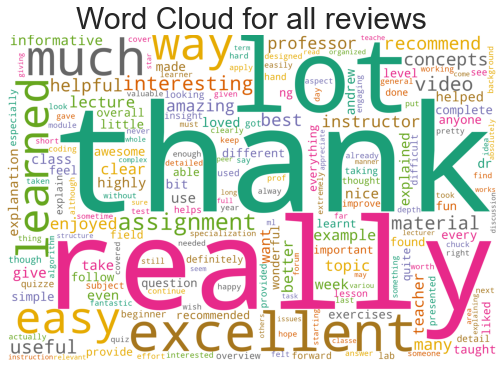

In [42]:
wordcloud = wordcloud_conversion(entire_reviews)
plot_cloud(wordcloud)
plt.title('Word Cloud for all reviews', fontsize=30);

- This is the Word cloud for all reviews. 
- The size of the word in the Word Cloud indicates its frequency. 
- From this plot, we can observe that most of the reviewers leave positive words in their reviews, however this could be because most reviews have 5.0 `rating`

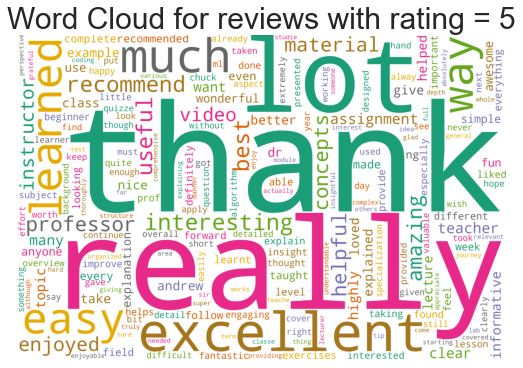

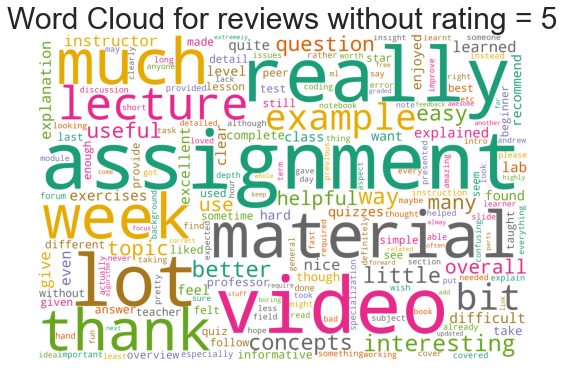

In [43]:
wordcloud_5 = wordcloud_conversion(rating_5_reviews)
plot_cloud(wordcloud_5)
plt.title('Word Cloud for reviews with rating = 5', fontsize=30);

wordcloud_not_5 = wordcloud_conversion(rating_not_5_reviews)
plot_cloud(wordcloud_not_5)
plt.title('Word Cloud for reviews without rating = 5', fontsize=30);

- 2 different Word Clouds are plotted. 
- The first is for reviews with `rating` = 5.0 while the second is for reviews with `rating` less than 5.0.
- Word Cloud with `rating` = 5.0 indicates high frequency of positive words: 'thank', 'much', 'excellent', 'learned'
- Word Cloud with `rating` less than 5 indicates high frequency of words regarding course materials: 'assignment', 'material', 'video', 'lecture'

### 7. Plotting Unigram Barplots

 - barplots are plotted to visualize the actual frequency of unigram, bigram and trigram 
 - in comparing the unigram, bigram and trigrams: they show a similar pattern to the word clouds plotted 

In [44]:
def unigram_count(string_of_words, color):
    df_dict = dict()
    for word in string_of_words.split():
        if word not in df_dict:
            df_dict[word] = 1
        else:
            df_dict[word] += 1
            
    df = pd.DataFrame(list(df_dict.items()), columns=['Unigram','Frequency']).sort_values(by='Frequency', ascending=False).head(10)
    plt.figure(figsize=(12,5))
    sns.barplot(x='Unigram', y ='Frequency', data=df, palette = color)

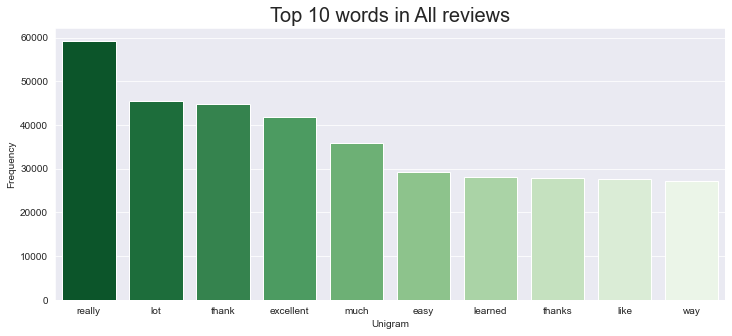

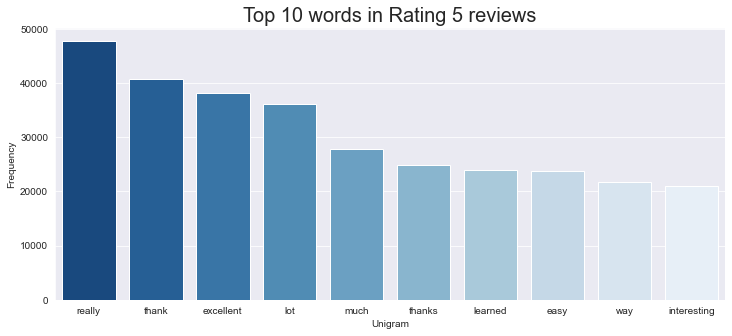

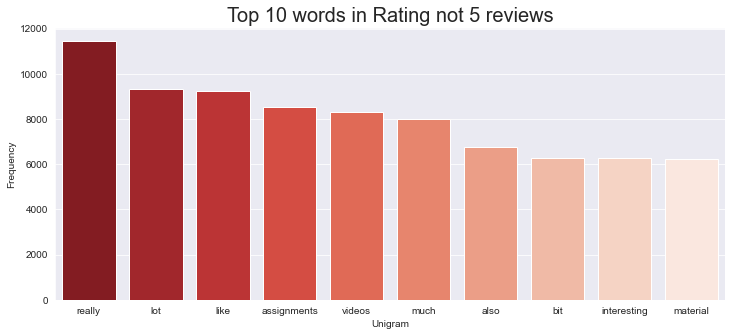

In [59]:
unigram_count(entire_reviews, 'Greens_r')
plt.title('Top 10 words in All reviews', fontsize=20);

unigram_count(rating_5_reviews, 'Blues_r')
plt.title('Top 10 words in Rating 5 reviews', fontsize=20);

unigram_count(rating_not_5_reviews, 'Reds_r')
plt.title('Top 10 words in Rating not 5 reviews', fontsize=20);

### 8. Plotting Bigram/Trigram Barplots

In [46]:
def bigram_trigam_count(df, color):
    count_vec = CountVectorizer(max_features=100, ngram_range=(2,3))
    ngrams = count_vec.fit_transform(df['reviews'])
    count_values = ngrams.toarray().sum(axis=0)
    vocab = count_vec.vocabulary_
    df_ngram = pd.DataFrame(((k,count_values[i]) for k,i in vocab.items()),
                        columns=['Bigram/Trigram','Frequency']).sort_values(by='Frequency', ascending=False).head(10)
    
    plt.figure(figsize=(18,5))
    sns.barplot(x='Bigram/Trigram', y ='Frequency', data=df_ngram, palette = color)

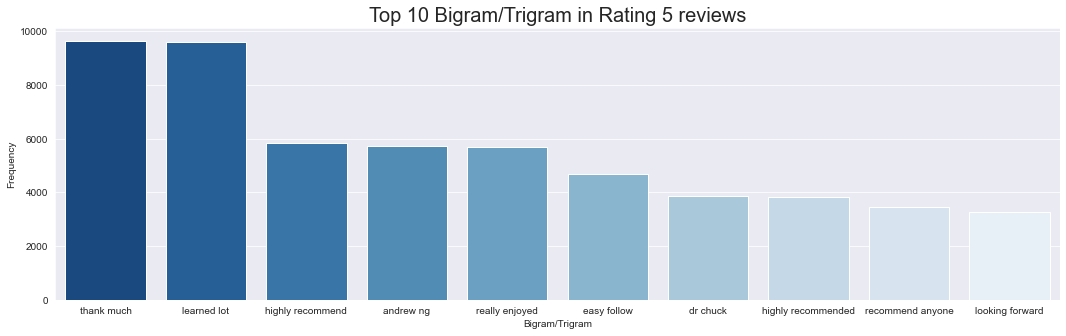

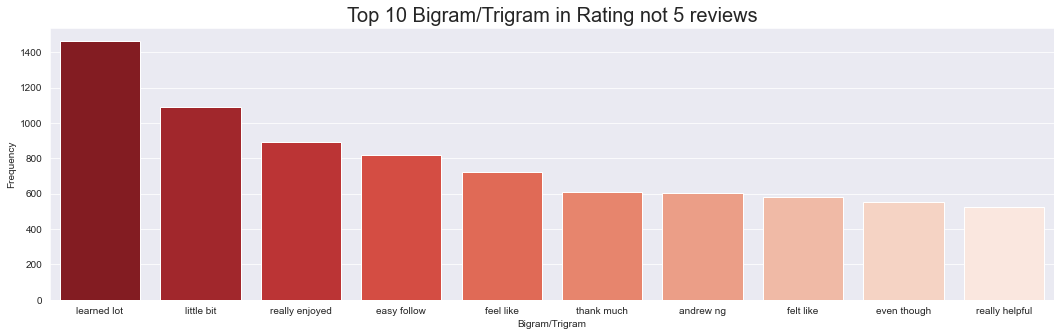

In [47]:
bigram_trigam_count(rating_5 ,'Blues_r')
plt.title('Top 10 Bigram/Trigram in Rating 5 reviews', fontsize=20);

bigram_trigam_count(rating_not_5 ,'Reds_r')
plt.title('Top 10 Bigram/Trigram in Rating not 5 reviews', fontsize=20);

### 9. Visualizing topics using pyLDAvis

- **pyLDAvis** is used to identify and interpret different topics found in the `reviews`
- Nouns are extracted from `reviews` to identify what other topics reviewers might be discussing besides feelings towards course content
- in plotting **pyLDAvis**, there are 2 main clusters: 
  - 1) showing gratitude towards instructors 
  - 2) specific skillsets like SQL, python and terms like engineer programming
  
- However, in trying to find topics in Coursera reviews, they are not very conclusive, decided to leave the pyLDAvis plot as part of the EDA process

In [3]:
from nltk import word_tokenize, pos_tag
from sklearn.decomposition import LatentDirichletAllocation

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
def review_to_lda(raw_review):
    # 1. Remove HTML.
    #review_text = BeautifulSoup(raw_review).get_text()
    
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',raw_review)
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    # 5. Remove stopwords.
    stops_words = list(stops) + ['course', 'courses', 'coursera']
    meaningful_words = [w for w in words if w not in stops_words]
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words)) 

In [7]:
lda_df = translated_df

lda_df['reviews']= lda_df['reviews'].apply(review_to_lda)

### Finding Nouns from Text

In [8]:
from nltk import word_tokenize, pos_tag
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN' # to find the nouns from the reviews, they have pos tag 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [9]:
lda_df['reviews']= [nouns(review) for review in lda_df['reviews']]

In [10]:
lda_df['reviews'][:10]

0    way topics examples help lot process food anim...
1    content look choice food value products compon...
2    initiation topics help lead lasts time issue i...
3    videos test problem understand someone recomme...
4    love see care health maintenance prevention wa...
5    moments health maya person benditions hug team...
6    emphasis solutions science food groups advice ...
7    feel videos understand anyone food affects hea...
8    tools tips explanations issue nutrition health...
9    introductory trip tips lifestyles options trac...
Name: reviews, dtype: object

In [11]:
cvn = CountVectorizer(stop_words='english',max_features=1000, ngram_range=(1,2))
data_cvn = cvn.fit_transform(lda_df['reviews'])

In [12]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(data_cvn)

LatentDirichletAllocation(n_components=20, random_state=0)

In [13]:
vis_data  = pyLDAvis.sklearn.prepare(lda_tf, data_cvn, cvn)
pyLDAvis.display(vis_data)

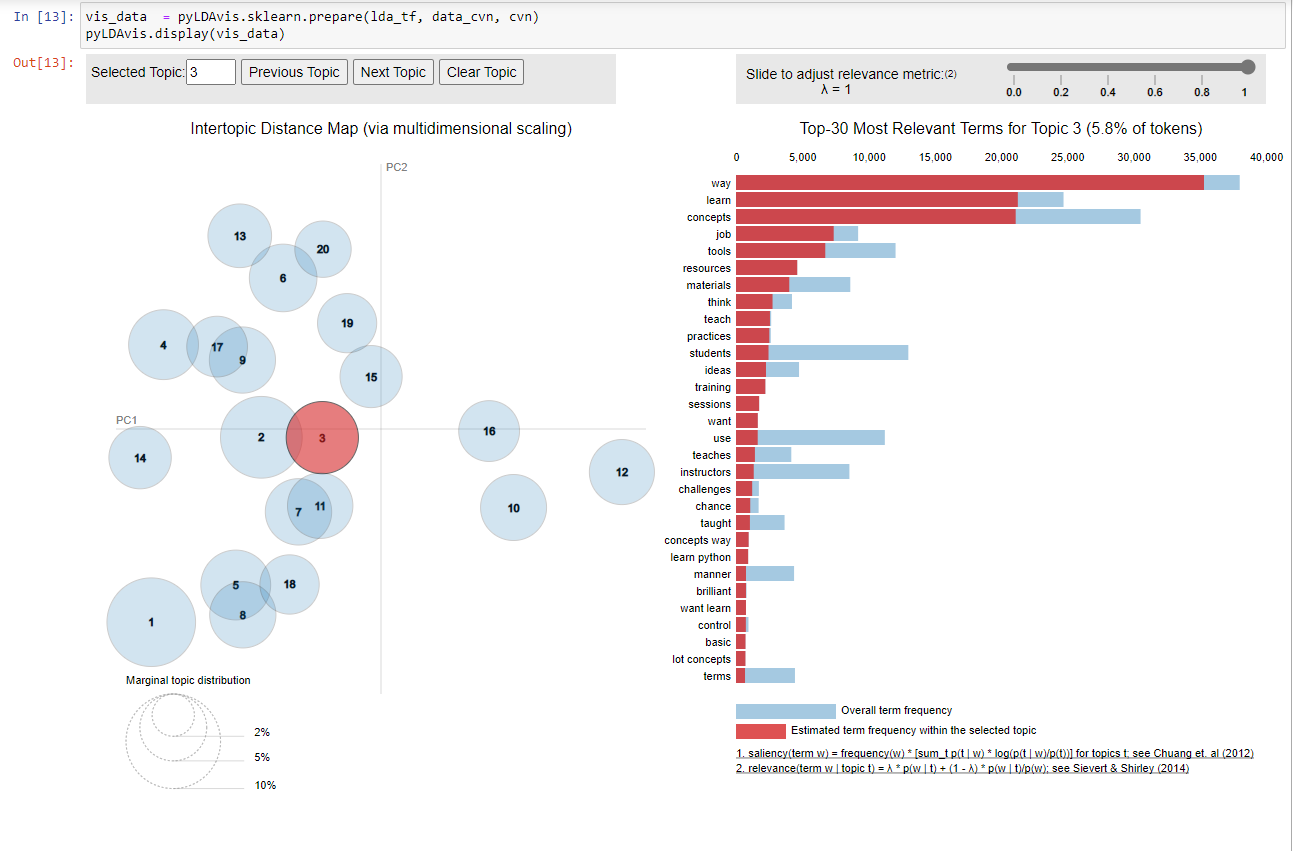

In [14]:
from IPython.display import Image
Image(filename='pyldavis.png')

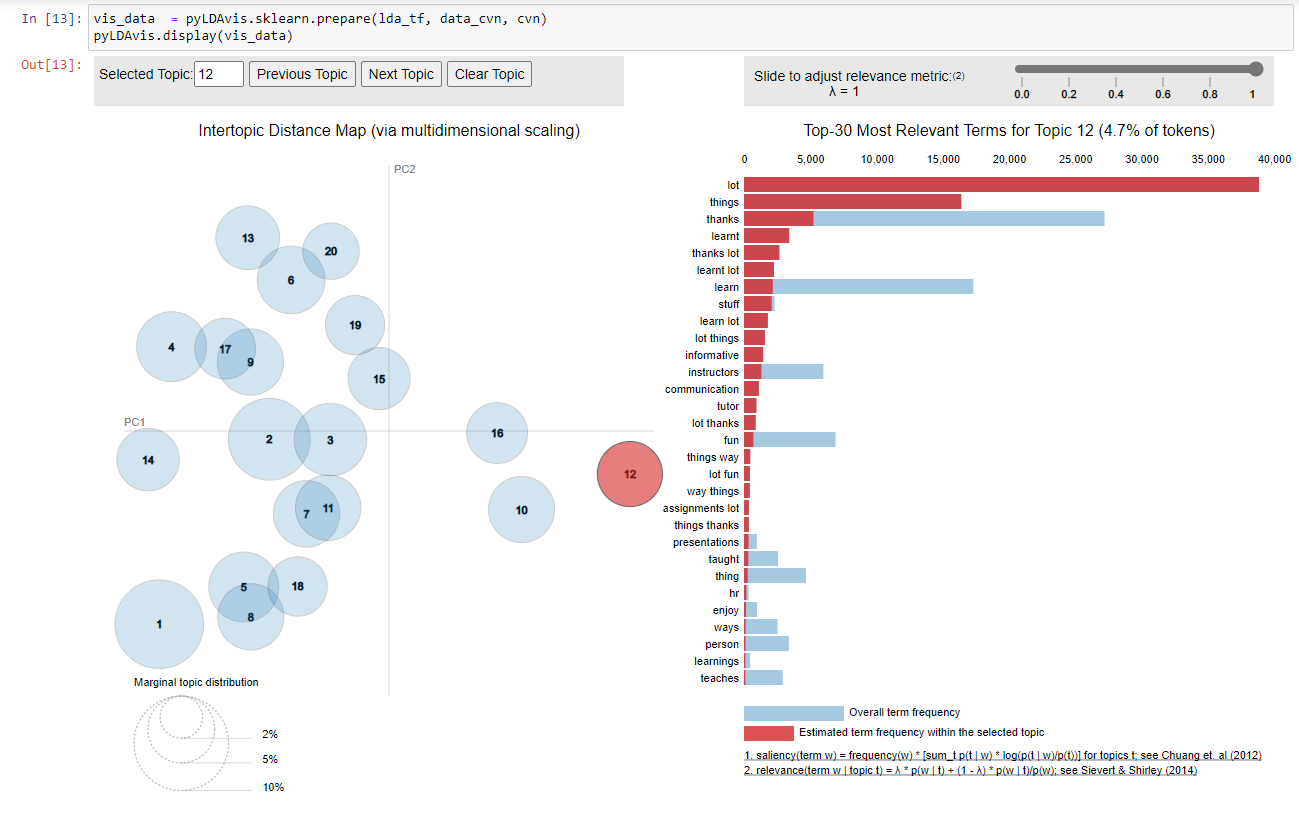

In [15]:
Image(filename='pyldavis2.png')

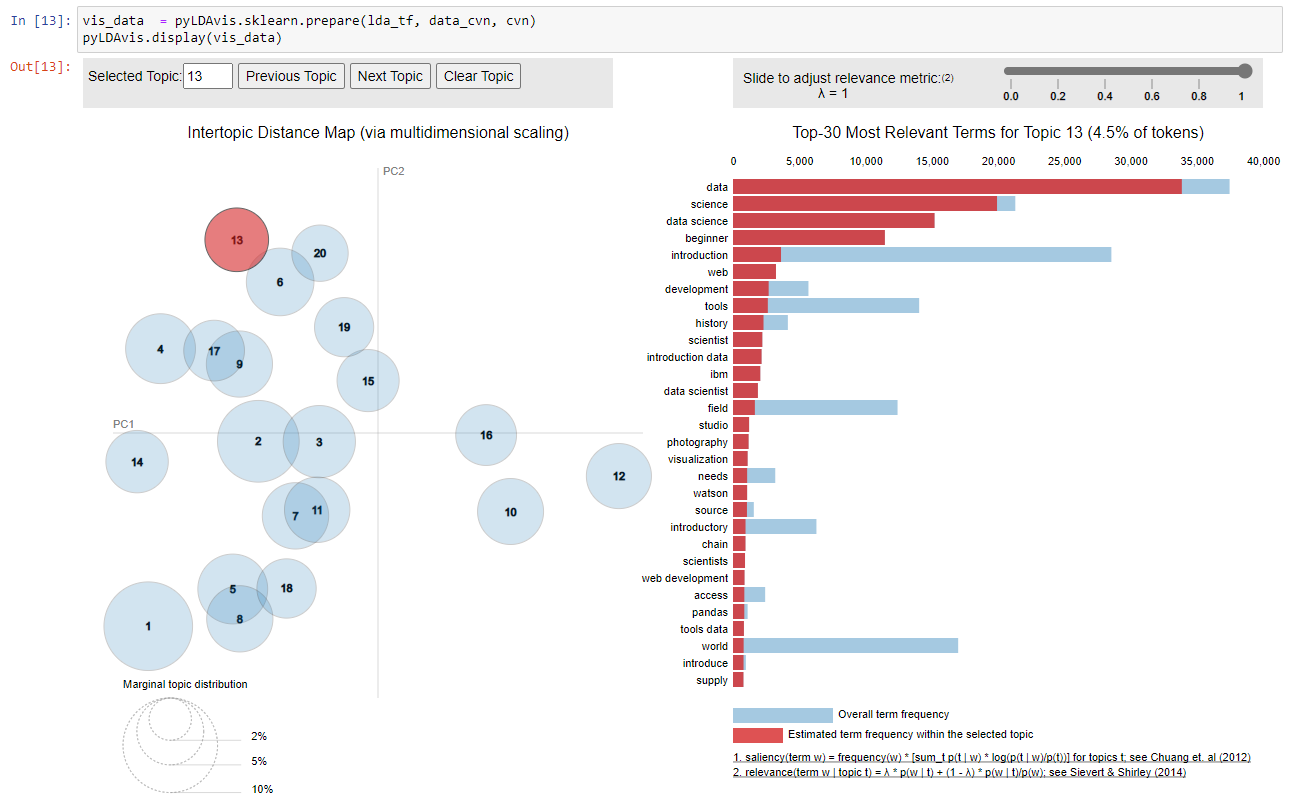

In [16]:
Image(filename='pyldavis3.png')